# 8-1 使用 LSTM 產生文字資料

### 程式 8.1 建立針對不同的 temperature 設定，重新加權，計算新的機率分佈的函式 

In [0]:
import numpy as np

def reweight_distribution(original_distribution, temperature=2):
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    return distribution / np.sum(distribution)

###  驗證重新加權，計算新的機率分佈的函式

In [0]:
ori_dstri = np.array([0.8, 0.1, 0.1])   # a、b、c 的機率分布

new_dstri = reweight_distribution(ori_dstri, 
                                  temperature=0.01)  # 使用溫度 0.01 
print(new_dstri)    # [1.00000000e+00 4.90909347e-91 4.90909347e-91]

new_dstri = reweight_distribution(ori_dstri, 
                                  temperature=2) # 使用預設溫度 2
print(new_dstri)    # [0.58578644 0.20710678 0.20710678]

new_dstri = reweight_distribution(ori_dstri, 
                                  temperature=10) # 使用溫度 10
print(new_dstri)    # [0.38102426 0.30948787 0.30948787]

[  1.00000000e+00   4.90909347e-91   4.90909347e-91]
[ 0.58578644  0.20710678  0.20710678]
[ 0.38102426  0.30948787  0.30948787]


### 程式 8.2 下載和解析初始文字文件

In [0]:
import keras
import numpy as np

path = keras.utils.get_file(        # 取得文本檔案
    'nietzsche.txt',                # 檔名 
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')  # 檔案位置
text = open(path, encoding='utf-8').read().lower()    # 讀取文本內容，並轉成小寫
print('Corpus length:', len(text))  # 文本長度為 600893

Corpus length: 600893


### 程式 8.3 向量化字元序列

In [0]:
maxlen = 60     # 每次 (step) 從文本中萃取 60 個字元作為序列資料
step = 3        # 每 3 個字元為一個 step 進行萃取 

sentences = []  # 存放萃取出的序列資料
next_chars = [] # 存放對應目標 (萃取出來的序列資料的後一個字元)

# 萃取序列資料 
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))   # 共萃取出 200278 個序列資料

# 產生文本中的 "唯一" 字元串列 (文本轉成 set 將重複字元刪除)
chars = sorted(list(set(text))) 
print('Unique characters:', len(chars)) # 文本共使用 57 種字元

# 將各個字元對應到 "chars" 串列中的索引值成為字典 (dict) 格式。即 {'\n': 0,' ': 1, '!': 2,…}
char_indices = dict((char, chars.index(char)) for char in chars)

# 將字元經 One-hot 編碼成二元陣列
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print(x.shape)  # (200278, 60, 57)
print(y.shape)  # (200278, 57)

Number of sequences: 200278
Unique characters: 57
Vectorization...
(200278, 60, 57)
(200278, 57)


### 程式 8.4 建立用於預測下一字元的模型

In [0]:
from keras import layers

model = keras.models.Sequential()   # 建立序列式模型
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

### 程式 8.5 模型編譯設定

In [0]:
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

### 程式 8.6 建立從給定模型預測結果中取樣下一個字元的函數

In [0]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature     # 重新加權計算 (熵)
    exp_preds = np.exp(preds)               
    preds = exp_preds / np.sum(exp_preds)   
    probas = np.random.multinomial(1, preds, 1) # 丟入多項式分布中
    return np.argmax(probas)

### 程式 8.7 循環的文字生成

In [0]:
import random
import sys

for epoch in range(1, 60):  # 共 60 個訓練週期 (次數)
    print('epoch', epoch)
    model.fit(x, y,         # 用萃取出來的 x, y 開始進行訓練
              batch_size=128,
              epochs=1)
    # 隨機選擇文本中的某段 60 個字元
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index: start_index + maxlen]
    print('--- 隨機初始文字: "' + generated_text + '"')

    # 嘗試使用一系列不同 temperature 生成文字
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # 每個 temperature 生成 400 個字元
        for i in range(400):    
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.
            preds = model.predict(sampled, verbose=0)[0]    # 產生字元機率分布
            next_index = sample(preds, temperature) # 重新加權並取樣，回傳字元索引
            next_char = chars[next_index]           # 確認新字元
            generated_text += next_char             # 新字元加到文字的後方
            generated_text = generated_text[1:]     # 重新取得含括新字元的文字繼續生成下一個字元

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
Epoch 1/1
200278/200278 [==============================] - 351s 2ms/step - loss: 2.0156
--- 隨機初始文字: "narrowest, meanest, least developed and yet cannot help look"
------ temperature: 0.2
narrowest, meanest, least developed and yet cannot help look of the and the such the self-contervance of a more and the every and the experience of the more the such and the are and the soult the sure of the and the existion of the supery the acconsedting and the superness and the great the great the such and and the predession of the man and instinction of the every in the such in the expressition of the fained the selution of the believe and the more and
------ temperature: 0.5
n of the fained the selution of the believe and the more and such good every not and spretures to the grean in a ditcherding bad a dought in and as as and man of live man. the believe and the double in the consciritater as and and thing to belient of the which and mantion of the belien it is a more not such in the ende

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


ifijur many
strong, a scient into strength of the worsd of hikee
begleging god who cersees nobes--and
the obcag--and
they subver aldo
------ temperature: 1.2
g god who cersees nobes--and
the obcag--and
they subver aldotion variacicism which was puilier vilosihate
woman-in history
is accort of certainlative pletecs."

2a demociter to flamily and formused
to his mad of thus bemad the mediococeve
an un"forgother with europe" for
stord
mus
just his nature" are doisefacs egoisous nal, without so nem sciente," the have its
long abovers: thus by many daric naidist of man not-broughts--it on that prequarity. though to 
epoch 7
Epoch 1/1
200278/200278 [==============================] - 350s 2ms/step - loss: 1.4501
--- 隨機初始文字: "value, which have become prevalent, and are for
a time calle"
------ temperature: 0.2
value, which have become prevalent, and are for
a time called the man and the contrary and the same of the extrars of the fact of the soul, and in the contrary of the most to the spirit 

KeyboardInterrupt: 

# 8-2 DeepDream

### 程式 8.8 載入預先訓練的 Inception V3 模型

In [0]:
from keras.applications import inception_v3
from keras import backend as K    #匯入 Keras 的後端功能


# ↓ 我們不會訓練這模型，因此使用此方法中止所有訓練相關的操作
K.set_learning_phase(0)

                                    # ↓ 該模型將載入預先訓練的 ImageNet 權重
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)
                                    # ↑ 此 InceptionV3 神經網路
                                    #       不包含最上層的全連接層，說明如下小編補充。

Using TensorFlow backend.














87916544/87910968 [==============================] - 1s 0us/step


### 程式 8.9 選擇 Inception V3 模型的其中 4 個層並設定貢獻係數

In [0]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
    # ↑ InceptionV3 中層的名稱
}

### 程式 8.10 定義損失最大化

In [0]:
# ↓ 建立一個將層名稱 (key) 對應到層物件 (value) 的字典
layer_dict = dict([(layer.name, layer) for layer in model.layers])
# ↓ 用 keres 的後端 (目前為 tensorflow) 建立一個純量變數 (初始值為 0)
loss = K.variable(0.)   # 稍後透過加上層的貢獻度到此純量變數來定義損失

for layer_name in layer_contributions:  
    coeff = layer_contributions[layer_name]     # 取出該層的貢獻係數
    activation = layer_dict[layer_name].output  # 取出該層的啟動函數輸出值 (即輸出張量)
    
    scaling = K.prod(K.cast(K.shape(activation), 'float32')) # 計算輸出張量元素總數做為縮放係數
    

    # ↓ 將各層的輸出張量進行元素平方後相加，
    # 並乘上貢獻度、除以縮放係數後 (L2 norm)，做為損失值。 
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling
                                                # ↑ 為避免處理邊界圖像，
                                                #     我們只處理非邊界的像素至損失中

### 補充：使用後端 tensorflow 對張量進行操作

In [0]:
from keras import backend as K

tf_session = K.get_session()    # 取得後端 tensorflow 的 session
tensor = K.constant([[1, -2], [3, 4]])  # 以後端建立一個張量常數

# 1. shape() 取得張量的 shape 大小
print('shape:')
print(K.shape(tensor).
      eval(session=tf_session))    # 張量 shape：[2 2]

# 2. cast() 將張量元素轉成浮點數型態
print('cast:')
print(K.cast(tensor, 'float32').    # 張量浮點數：[[-1.  2.]
      eval(session=tf_session))     #             [ 3.  4.]]

# 3. abs() 將張量元素取絕對值 
print('abs:')                                                     
print(K.abs(tensor).                # 張量絕對值 [[1 2]
      eval(session=tf_session))     #            [3 4]]
                                
# 4. prod() 將張量元素相乘 
print('prod:')                                                   
print(K.prod(tensor).
      eval(session=tf_session))    # 張量元素相乘：-24

# 5. sum() 將張量元素相加
print('sum:') 
print(K.sum(tensor).
      eval(session=tf_session))    # 張量元素相加：6

# 6. maximum() 將小於門檻值的張量元素以門檻值取代
print('maximum:') 
print(K.maximum(tensor, 2).
      eval(session=tf_session))       # 比 2 小的元素被 2 取代了

# 7. square() 將張量元素進行平方運算
print('square:') 
print(K.square(tensor).             # 張量平方值 [[  1.   4.]
      eval(session=tf_session))     #             [  9.  16.]]

# 8. permute_dimensions() 將 shape 依據變換規則進行變換
    # shape (1, 2, 3) --> (3, 1, 2)  因為指定了 (2,0,1) 代表:位置 2 變成 位置 0
    #                                                       位置 0 變成 位置 1    
    #                                                       位置 1 變成 位置 2
print('permute_dimensions:')    
tensor = K.constant([[[1, 2, 3], 
                       [4, 5, 6]]])  # 以後端建立一個 3 維張量常數
print(K.permute_dimensions(tensor, (2, 0, 1)).            
      eval(session=tf_session))  

# 9. batch_flatten() 將張量拉平成矩陣，即 shape = (1, n)
print('batch_flatten:') 
tensor = K.constant([[[1, 2], 
                       [3, 4],
                       [5, 6]]])  
print(K.batch_flatten(tensor).            
      eval(session=tf_session))  

# 10. transpose() 將 shape 倒轉, 例如 (1,2,3) -> (3,2,1) 
print('transpose:') 
tensor = K.constant([[[1, 2, 3], 
                       [4, 5, 6]]])  # 以後端建立一個 3 維張量常數 
print(K.transpose(tensor).            
      eval(session=tf_session)) 

# 11. dot() 將進行矩陣內積
print('dot:') 
matrixA = K.constant([[1, 3, 5]])           # 建立矩陣 A, shape = (1,3)
matrixB = K.constant([[[2],[4],[6]]])       # 建立矩陣 B, shape = (3,1)
print(matrixB.eval(session=tf_session))
print(K.dot(matrixA, matrixB).            
      eval(session=tf_session))      # A 與 B 內積 = [[[1x2 + 3x4 + 5x6]]] = [[[44.]]]
                                     # 註：若 B 為 A 的轉置矩陣, 則內積結果稱為格拉姆矩陣


# 12. pow() 對張量元素進行特定次方運算
tensor = K.constant([[1, -2], [3, 4]])  
print('pow:') 
print(K.pow(tensor, 2).            # [[ 1.  4.]
      eval(session=tf_session))     #  [ 9. 16.]]


shape:
[2 2]
cast:
[[ 1. -2.]
 [ 3.  4.]]
abs:
[[1. 2.]
 [3. 4.]]
prod:
-24.0
sum:
6.0
maximum:
[[2. 2.]
 [3. 4.]]
square:
[[ 1.  4.]
 [ 9. 16.]]
permute_dimensions:
[[[1. 4.]]

 [[2. 5.]]

 [[3. 6.]]]
batch_flatten:
[[1. 2. 3. 4. 5. 6.]]
transpose:
[[[1.]
  [4.]]

 [[2.]
  [5.]]

 [[3.]
  [6.]]]
dot:
[[[2.]
  [4.]
  [6.]]]
[[[44.]]]
pow:
[[ 1.  4.]
 [ 9. 16.]]


### 程式 8.12梯度上升處理程序

In [0]:
dream = model.input     # 設定 V3 模型的輸入
print(dream.shape)      # 其輸入格式為彩色圖片 (3-channels) shape = (?,?,?,3)


# 後端的 gradients() 可以根據 loss 計算 dream 的梯度
grads = K.gradients(loss, dream)[0]    
                               # ↑ 因為我們只輸入一個張量，所以是第一筆的輸出結果
print(grads.shape)  # 此梯度結果是一個張量，與 dream 大小相同                               

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)  # 正規化梯度 (重要技巧)
                                           # 防止除以低於 0.0000001 的值而造成梯度太高

# 在給定輸入圖像的情況下，自訂一個 Keras 函數以取得損失值和梯度值
outputs = [loss, grads]     # 設定輸出串列
fetch_loss_and_grads = K.function([dream], outputs)
# ↑ 函式名稱                # 設定輸入 ↑      # ↑ 設定輸出

# 取得損失及梯度
def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])    # 呼叫函數取得輸出 outs = [損失, 梯度]
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

# 執行梯度上升
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations): 
        loss_value, grad_values = eval_loss_and_grads(x)    # 取得損失及梯度
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        # print('...grad value at', i, ':', grad_values)  # 若印出梯度，可以觀察到最後梯度會趨近於 0 
        x += step * grad_values     # 將圖片與梯度進行相加
    return x

(?, ?, ?, 3)
(?, ?, ?, 3)


### 程式 8.13 輔助函數 (為了解說清楚, 我們將原書程式 8.13 移到 8.12 前面了)

In [0]:
import scipy
import numpy as np
from keras.preprocessing import image   # 匯入 Keras image 對圖片進行預處理的功能

# 對圖片進行 Inception V3 預處理
def preprocess_image(image_path):
    img = image.load_img(image_path)    # 根據路徑載入圖片
    img = image.img_to_array(img)       # 將圖片轉成陣列 array
    print(img.shape)                    # 例如：(682, 1024, 3)，1024x682 的彩色圖片
    img = np.expand_dims(img, axis=0)   # 以軸 0 對 array 的 shape 進行擴展
    print(img.shape)                    # 例如：擴展後的 shape (1, 682, 1024, 3)
    img = inception_v3.preprocess_input(img) # 將圖像預處理為 Inception V3 可以處理的張量
    return img

# 將 Inception V3 所做的預處理進行反向操作，轉回圖片格式
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')  # 將數字限制在 0-255 之間
    return x

# 進行圖片的比例縮放
def resize_img(img, size):      
    img = np.copy(img)
    # 先設定縮放因子，可以想像原本的 shape (1, width, height, 3) 
    # 會乘上這個 factor 
    factors = (1,       
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    # 將以樣條插直法的技術對圖片進行縮放，其中 order 為樣條插值法的次數
    return scipy.ndimage.zoom(img, factors, order=1)    


# 儲存圖片，儲存前要先反轉 Inception V3 所做的預處理
def save_img(img, fname):       
    pil_img = deprocess_image(np.copy(img))     # 反轉
    #scipy.misc.imsave(fname, pil_img)
    # 由於 imsave() 方法將在 SciPy 1.2.0 時被移除，官方建議我們改用 imageio.imwrite
    import imageio
    imageio.imwrite(fname, pil_img)

### 程式 8.14 在不同的連續比例的圖片上執行梯度上升

In [0]:
step = 0.01             # 每次梯度上升的變化量
num_octave = 3          # 執行梯度上升的比例數量
octave_scale = 1.8      # 比例間的大小比率
iterations = 20         # 每個比例下執行的梯度上升的次數
max_loss = 10.          # 如果損失大於 10，則中斷梯度上升，以避免產生醜陋的圖像

base_image_path = 'original_photo_deep_dream.jpg'   # 基底圖片的檔案位置
img = preprocess_image(base_image_path) # 載入圖片並進行預處理

original_shape = img.shape[1:3]         # 取得圖片的原比例寬高 (tuple)
successive_shapes = [original_shape]    # 將不同比例的寬高存入一個 list 中
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
# 請注意!產生的寬高比例為 原比例、縮小 1.4 倍、縮小 1.4x1.4 倍
successive_shapes = successive_shapes[::-1] # 反轉寬高比例 list，使它們按順序遞增 

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0]) # 產生最小的圖片

for shape in successive_shapes:     # 開始逐次放大圖片 (八階圖)
    print('Processing image shape', shape)
    img = resize_img(img, shape)    # 放大圖片，在這裡就已經損失細節了，注意！第一次
                                    # 進到迴圈時，img 是由最大變成最小
    img = gradient_ascent(img,                      # 執行梯度上升，改變 img 圖片
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    # 將小比例的圖片放大至目前比例，會造成像素顆粒化 (小變大，損失細節)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    # 將原始圖片縮小至目前比例 (大變小，保有細節)
    same_size_original = resize_img(original_img, shape)
    # 相減求得損失的細節，例如原有 A+B，放大後只剩 A，(A+B) - (A) = (B) 損失的東西 
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail              # 將細節加回圖片中
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='final_dream.png')

(827, 1280, 3)
(1, 827, 1280, 3)
Processing image shape (255, 395)


/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


...Loss value at 0 : 1.2631427
...Loss value at 1 : 1.6214535
...Loss value at 2 : 2.1713052
...Loss value at 3 : 2.8097286
...Loss value at 4 : 3.471332
...Loss value at 5 : 4.1580443
...Loss value at 6 : 4.8112607
...Loss value at 7 : 5.4206166
...Loss value at 8 : 6.0376525
...Loss value at 9 : 6.678784
...Loss value at 10 : 7.25094
...Loss value at 11 : 7.834009
...Loss value at 12 : 8.362862
...Loss value at 13 : 8.912173
...Loss value at 14 : 9.46156
...Loss value at 15 : 9.943583
Processing image shape (459, 711)
...Loss value at 0 : 2.290426
...Loss value at 1 : 3.1904356
...Loss value at 2 : 4.012931
...Loss value at 3 : 4.8489013
...Loss value at 4 : 5.680361
...Loss value at 5 : 6.472816
...Loss value at 6 : 7.2852917
...Loss value at 7 : 8.055797
...Loss value at 8 : 8.8414345
...Loss value at 9 : 9.584444
Processing image shape (827, 1280)
...Loss value at 0 : 2.3719513
...Loss value at 1 : 3.2556632
...Loss value at 2 : 4.166143
...Loss value at 3 : 5.259649
...Loss value

###  顯示 DeepDream 圖片

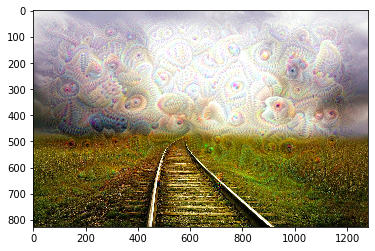

In [0]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

# 8.3 神經風格轉換

### 8.14 設定圖片路徑與調整高度

In [0]:
from keras.preprocessing.image import load_img, img_to_array

target_image_path = 'target.jpg'         # 目標圖片的路徑
style_reference_image_path = 'style.jpg'  # 風格參考圖片的路徑

# 以目標圖片的寬高比來設定生成圖片的高 (400px) 與對應的寬
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

### 程式 8.15 輔助函數

In [0]:
import numpy as np
from keras.applications import vgg19    # 匯入 VGG19 模型

def preprocess_image(image_path):
    img = load_img(image_path,          # 載入圖片，並以指定的尺寸進行調整，shape = (img_height,img_width,3)
                   target_size=(img_height, img_width))
    img = img_to_array(img)             # 將圖片轉為 array
    img = np.expand_dims(img, axis=0)   # 擴展維度 => shape = (1,img_height,img_width,3)
    img = vgg19.preprocess_input(img)   # 將圖片預處理為 VGG19 可以處理的張量格式 
    return img

def deprocess_image(x):
    # 對各個 channel 加回 ImageNet 的 channel 平均像素值，
    # 這反轉了 vgg19.preprocess_input 預處理所進行的 0 中心化
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]   # 將圖片 channel 從 'BGR' 轉換為 'RGB'。這也是反轉 vgg19.preprocess_input 的預處理
    x = np.clip(x, 0, 255).astype('uint8')  # 將數字限制在 0-255 之間
    return x

### 程式 8.16 載入預先訓練的 VGG19 神經網路並將其應用於三個圖片

In [0]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

combination_image = K.placeholder((1, img_height, img_width, 3))    # 預留位置將用來儲存生成圖片

# 將這三個圖片張量串接成一批次張量
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# 使用一批三個圖片張量作為輸入以建構 VGG19 神經網路。該模型將載入預先訓練的 ImageNet 權重
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

80142336/80134624 [==============================] - 1s 0us/step
Model loaded.


### 程式 8.17 定義內容損失

In [0]:
                # ↓ 目標圖片  # ↓ 生成圖片
def content_loss(base, combination):
    return K.sum(K.square(combination - base))  # 圖片張量元素相減後的平方和

### 程式 8.18 定義風格損失

In [0]:
def gram_matrix(x): # 計算格拉姆矩陣，以下矩陣運算請參考程式 8.5 的第 8~11 項說明
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram
              # ↓ 風格參考圖片 # ↓ 生成圖片
def style_loss(style, combination): # 
    S = gram_matrix(style)          # 取得風格參考圖片的格拉姆矩陣
    C = gram_matrix(combination)    # 取得生成圖片的格拉姆矩陣
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))    
            # 格拉姆矩陣元素相減後的平方和

### 程式 8.19 總變異損失

In [0]:
                       # ↓ 生成圖片
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))
                    # 張量次方運算請參考 8.5.py 的第 12 點

### 程式 8.20 定義將要最小化的最終損失

In [0]:
# ↓ 建立一個將層名稱 (key) 對應到層物件的啟動函數輸出張量 (value) 的字典
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = 'block5_conv2'  # 要用於內容損失的層名稱
# 要用於風格損失的層名稱
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# 三種損失的加權平均值的權重
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

loss = K.variable(0.)   # 透過將所有損失加到此純量變數來定義總損失

# 計算內容損失並加到總損失中
layer_features = outputs_dict[content_layer]
# 0 是因為將三個圖片張量串接輸入到 VGG19 時，目標圖片張量為第 1 個
target_image_features = layer_features[0, :, :, :]  
combination_features = layer_features[2, :, :, :]   # 生成圖片為第 3 個
loss += content_weight * content_loss(target_image_features,
                                      combination_features)

# 計算指定的層所產生的風格損失並加到總損失中                 
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]   # 風格圖片為第二個
    combination_features = layer_features[2, :, :, :]       # 理由同上
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

# 計算總變異損失並加到總損失中
loss += total_variation_weight * total_variation_loss(combination_image)

### 程式 8.21 設定梯度下降處理程序

In [0]:
# 後端的 gradients() 可以根據 loss 計算生成圖片對應的梯度
grads = K.gradients(loss, combination_image)[0]
                                            # ↑ 因為我們只輸入一個張量，所以是第一筆的輸出結果
fetch_loss_and_grads = K.function([combination_image], [loss, grads]) # 用於取得目前損失值與梯度值的函數


# 這個類別以透過兩個單獨方法呼叫的方式，取得損失值和梯度值，
# 並封裝成 fetch_loss_and_grads 方式，這是 SciPy 優化器所要求的
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):                      # 第一次呼叫取得損失值
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])    # 取得損失值與梯度值
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values      # 將梯度值先暫存在記憶體
        return self.loss_value

    def grads(self, x):                     # 將暫存於記憶體的梯度值回傳
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()     # 實例化 Evaluator 物件

### 程式 8.22 以 L-BFGS 優化器進行梯度下降, 進行神經風格轉換

In [0]:
from scipy.optimize import fmin_l_bfgs_b    # L-BFGS 優化器
#from scipy.misc import imsave               # 儲存圖片功能
import time                                 

result_prefix = 'style_transfer_result'     # 生成圖片的檔名
iterations = 20                             # 迭代總次數                         

x = preprocess_image(target_image_path)     # 這是初始狀態：目標圖片
x = x.flatten()  # 將 array 變成 1 維 (拉平，scipy.optimize.fmin_l_bfgs_b 只能處理平面向量)
print(x.shape) 
for i in range(iterations):
    print(f'第 {i} 次迭代')
    start_time = time.time()           
    # 對生成圖像的像素執行L-BFGS優化以以最小化神經風格損失。
    # 注意到必須將計算損失值的函數與計算梯度值的函數作為兩個單獨的參數傳遞     
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,    # 要最小化的損失函數
                                     x,                         # 初始狀態圖片
                                     fprime=evaluator.grads,    # 梯度函數
                                     maxfun=20)
    print('目前損失值:', min_val)

    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)  
    fname = result_prefix + '_at_iteration_%d.png' % i
    import imageio
    imageio.imwrite(fname, img)
    #imsave(fname, img)
    end_time = time.time()
    print(f'圖片以檔名 {fname} 儲存')
    print(f'第 {i} 次迭代所花費的時間:{end_time - start_time}')

# 8.4 使用變分自編碼器生成圖像

### 程式 8.23 將輸入圖像 x 對應 (編碼) 到兩個向量

In [0]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # 潛在空間的維度 (數)：2D 平面

input_img = keras.Input(shape=img_shape)    # 建立原始圖像大小的輸入張量
print(input_img.shape) # 輸入張量 shape = (?, 28, 28, 1)
x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)

print(x.shape) # 經過卷積後的 shape = (?, 14, 14, 64)

shape_before_flattening = K.int_shape(x)    # 以 tuple 回傳張量的大小
print(shape_before_flattening)              # tuple: (None, 14, 14, 64)

x = layers.Flatten()(x)     # 將張量拉平 [[x1, x2,...]], shape = (?, ?)
x = layers.Dense(32, activation='relu')(x)
print(x.shape)  # shape = (?, 32)

# 輸入圖像最終被編碼成這兩個參數
z_mean = layers.Dense(latent_dim)(x)    # shape=(?,2)
z_log_var = layers.Dense(latent_dim)(x) # shape=(?,2)

(?, 28, 28, 1)
(?, 14, 14, 64)
(None, 14, 14, 64)
(?, 32)


### 程式 8.24 潛在空間的取樣函式

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)   # 產生隨機值
    return z_mean + K.exp(z_log_var) * epsilon      # 回傳取樣的點

z = layers.Lambda(sampling)([z_mean, z_log_var])    # 取樣出潛在空間中的點 z, shape = (?, 2)
print(z.shape)

(?, 2)


### 程式 8.25 VAE 解碼器神經網路，將潛在空間點 z 對應到 (轉換) 圖像

In [0]:
# 以 z 的大小建立一輸入張量, shape = (?, 2), 作為 z 的輸入
decoder_input = layers.Input(K.int_shape(z)[1:])    


                    # 元素相乘, 結果為 14x14x64 = 12544  # 拉平前的張量 shape = (14, 14, 64)
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)  # 對 z 進行上採樣
print(x.shape) # 進行上取樣後, shape = (?, 12544)

# 將 z 的 shape 重塑為與編碼器模型中最後一個 Flatte 層 (拉平) 之前的 shape 
x = layers.Reshape(shape_before_flattening[1:])(x)
print(x.shape) # shape = (?, 14, 14, 64)


# 使用 Conv2DTranspose 層 (反卷積) 和 Conv2D 層，將 z 解碼為與原始圖像輸入大小相同的特徵圖 (張量)
x = layers.Conv2DTranspose(32, 3,   # 反卷積
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
print(x.shape) # shape = (?, 28, 28, 32)

x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
print(x.shape) # shape = (?, 28, 28, 1), 已經將 z 的 shape 重朔成與原始圖像輸入張量相同

decoder = Model(decoder_input, x)   # 實例化解碼器模型，其可以將輸入張量 "decoder_input" 變為解碼圖像

decoder.summary()

z_decoded = decoder(z)  # 將輸入張量 z 輸入給解碼器模型, 得到了 z 的解碼圖像

(?, 12544)
(?, 14, 14, 64)
(?, ?, ?, 32)
(?, ?, ?, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape_3 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


### 程式 8.26 建立用於計算 VAE 損失的自定義層

In [0]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):   # 計算 VAE 損失
        x = K.flatten(x)                   
        z_decoded = K.flatten(z_decoded)    
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded) 
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):     # 透過撰寫 call 方法 (method) 來實作自定義層
        x = inputs[0]           # 輸入圖像
        z_decoded = inputs[1]   # 解碼圖像
        loss = self.vae_loss(x, z_decoded)  # 用兩者來計算 VAE 損失
        self.add_loss(loss, inputs=inputs)  # 將損失加到層之中
        return x                # 不會使用此輸出，但層必須回傳一些內容

# 以原始輸入和解碼輸出為基準，呼叫自定義層 (執行 call method)，以獲取計算 VAE 損失後的最終模型輸出
y = CustomVariationalLayer()([input_img, z_decoded])    
print(y.shape)  # 最終輸出為圖片, 其 shape = (?, 28, 28, 1)

(?, 28, 28, 1)


### 程式 8.27 訓練 VAE：使用 MNIST 資料

In [0]:
from keras.datasets import mnist

vae = Model(input_img, y)   # 以原始輸入與最終輸出來實例化 VAE 模型
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  after removing the cwd from sys.path.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_95[0][0]                  
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_96[0][0]                  
__________________________________________________________________________________________________
conv2d_98 

KeyboardInterrupt: 

### 程式 8.28 從 2D 潛在空間中取樣網格點並將其解碼為圖像

In [0]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15              # 顯示一個 15×15 位數的網格(總共 255 位數)
digit_size = 28     # 每個網格的尺寸 28x28
figure = np.zeros((digit_size * n, digit_size * n)) # shape = (420, 420)

# 使用 SciPy ppf 函式 (Percent point function) 
# 轉換線性空間坐標以生成潛在變數 z (因為潛在空間的分佈是採高斯常態 (Gaussian) 分佈)
# np.linspace(0.05, 0.95, n) 回傳 n 個分布在 0.05-0.95 之間的均勻數字
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2) # 重複 z 多次以形成完整批次
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)    # 解碼該批次成數字圖像
        digit = x_decoded[0].reshape(digit_size, digit_size)            # 將批次中的第一個數字從 28×28×1 重新塑形為 28×28
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

# 8.5 生成對抗網路

### 程式 8.29 GAN 生成器神經網路

In [0]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))  # 建立輸入張量, shape = (?, 32)

# 將輸入轉換成 16×16 128 層次 (channel) 的張量
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)
print(x.shape) # (?, 16, 16, 128)

# 加入卷積層 
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
print(x.shape) # (?, 16, 16, 256)

# 向上取樣成 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)
print(x.shape)  # 雖然從 shape 看不出來, 
                # 但從待會的 model.summary() 可以看出 shape=(None, 32, 32, 256)

# 使用更多的卷積
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)


x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x) # 產生 32×32 3 層次的特徵圖 (CIFAR10圖像的形狀)
generator = keras.models.Model(generator_input, x)   # 實例化生成器模型，將 shape=(latent_dim, )的輸入對應成 shape=(32,32,3) 的圖像
generator.summary()


(?, 16, 16, 128)
(?, 16, 16, 256)
(?, ?, ?, 256)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DT

### 程式 8.30 GAN 鑑別器神經網路

In [0]:
# 建立圖片尺寸的輸入張量, 其 shape=(?, 32, 32, 3)
discriminator_input = layers.Input(shape=(height, width, channels))

x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
print(x.shape) # 經過一連串的卷積 shape=(?, 2, 2, 128)

x = layers.Flatten()(x) # 拉平, 其 shape=(?, 512)

                    # 隨機丟棄 40 % 的神經元
x = layers.Dropout(0.4)(x)  # 一個重要的技巧：一個丟棄層！

x = layers.Dense(1, activation='sigmoid')(x)    # 分類層
print(x.shape) # 最終輸出 shape=(?, 1)

# 實例化鑑別器模型，其將 (32,32,3) 輸入圖片轉換為二元分類決策 (假/真)
discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008,       # 學習速率
                                                   clipvalue=1.0,   # 在優化過程中使用梯度遞減(依設定值)
                                                   decay=1e-8)      # 為了穩定訓練過程，使用學習速率衰減
discriminator.compile(optimizer=discriminator_optimizer, 
                      loss='binary_crossentropy')

(?, 2, 2, 128)
(?, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)        

### 程式 8.31 對抗神經網路

In [0]:
discriminator.trainable = False # 將鑑別器權重設定為不可訓練 (僅適用於gan模型)

gan_input = keras.Input(shape=(latent_dim,))        # 建立 GAN 的輸入張量 , shape=(?, 32)
gan_output = discriminator(generator(gan_input))    # 將輸入張量送入生成器產生圖片後, 再送入鑑別器分辨真假, shape=(?, 1)
gan = keras.models.Model(gan_input, gan_output)     # 實例化 GAN 模型
gan.summary()

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, 
                                         clipvalue=1.0, 
                                         decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

### 程式 8.32 實作 GAN 訓練

In [0]:
import os
from keras.preprocessing import image

# 載入 CIFAR10 資料
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# 選擇青蛙圖像 (類別6)
x_train = x_train[y_train.flatten() == 6]

# 標準化 (正規化) 資料
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = '/gan_images/'   # 指定要儲存生成圖像的位置

# 開始訓練
start = 0
for step in range(iterations):  # 進行 10000 步
    # 在潛在空間中取樣隨機的點
    random_latent_vectors = np.random.normal(size=(batch_size, 
                                                   latent_dim))

    # 產生成假圖像
    generated_images = generator.predict(random_latent_vectors)

    # 將假圖片與真實圖像相混合
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # 分配標籤，以從假圖像中辨別真的
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # 在標籤中增加隨機雜訊，這是一個重要技巧！
    labels += 0.05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, # 訓練鑑別器
                                          labels)  

    # 在潛在空間中取樣隨機的點
    random_latent_vectors = np.random.normal(size=(batch_size, 
                                                   latent_dim))

    # 分配標籤說 "這些都是真實圖像" (這是謊言!)
    misleading_targets = np.zeros((batch_size, 1))

    # 訓練生成器 (透過 gan 模型，其中鑑別器權重被凍結)
    a_loss = gan.train_on_batch(random_latent_vectors, 
                                misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    if step % 100 == 0:         # 每 100 步儲存並和繪製結果
        gan.save_weights('gan.h5')  # 儲存模型權重

        # 印出衡量指標
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # 儲存一個生成的圖像
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # 儲存一個真實圖像以進行比較
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))